# Readout Limits: 1.3
## Synthetic nulls

What would our best possible readout measure look like if we only had recordings from a small subset of the brain regions involved with a disease?

In this notebook I'll simulated various null distributions associated with different scenarios of our 'disease coverage' and then describe how these can be used to assess empirical readout performances.

## Setup

In [1]:
import networkx as nx
import numpy as np
import random

import matplotlib
import matplotlib.pyplot as plt


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score



matplotlib.rcParams['figure.figsize'] = (20,12)

class DevNull(object):
    def write(self,arg):
        pass
    
import sys
#sys.stdout = DevNull()

## Overview
Look at the literature and figure out what brain regions are involved in the disease you care about.
How many probes do you have?
How many of the disease-relevant brain regions do you have probes in?
That's your coverage $C\%$

Given a coverage, what's the best readout performance you can expect?

In [2]:
class readout:
    def __init__(self,N=500,B=1,M=1,T=100):
        self.N = N
        self.M = M
        self.B = B
        
        self.gamma_support = 10
        
        self.G = nx.erdos_renyi_graph(N,0.3)
        self.L = nx.laplacian_matrix(self.G).todense()
        
        self.state = np.random.normal(0,10,size=(N,100))
        
        self.design_gamma()
        self.design_H()
    def design_gamma(self,family='normal'):
        B = self.B
        N = self.N
        
        if family=='normal':
            self.gamma = np.random.normal(0,1,size=(B,N))
            self.gamma *= (np.abs(self.gamma) > 1).astype(np.int)
        elif family == 'steep':
            self.gamma = 10*np.random.beta(0.5,0.5,size=(B,N)) - 5
        elif family=='laplace':
            self.gamma = np.random.laplace(size=(B,N))
        idxs = np.argpartition(np.abs(self.gamma[0,:]),-self.gamma_support)[:-self.gamma_support]
        self.gamma[0,idxs] = 0
        #self.gamma *= (np.abs(self.gamma) > 2).astype(np.int)
        
    def design_H(self,family='optimal'):
        M = self.M
        N = self.N
        
        self.H = np.zeros((M,N))
        H_intermed = np.zeros((M,N))
        if family=='optimal':
            #find M largest gamma values
            idxs = np.argpartition(np.abs(self.gamma[0,:]),-M)[-M:]
            for ii,idx in enumerate(idxs):
                self.H[ii,idx] = 1
        elif family=='rand_in':
            #choose M random non-zero gamma spots
            disease_support = np.where(self.gamma != 0)[1]
            idxs = np.random.choice(disease_support,M)
            for ii,idx in enumerate(idxs):
                self.H[ii,idx]=1
        elif family=='rand_all':
            #choose M random ANY SPOT
            idxs = random.sample(range(N),M)
            for ii,idx in enumerate(idxs):
                self.H[ii,idx]=1
        elif family=='eye':
            eye = np.eye(self.N)
            M_idxs = random.sample(range(self.N),self.M)
            #self.H = np.random.choice([0,1],p=[1-coverage,coverage],size=(M,N))
            self.H = eye[M_idxs,:]
        
        #In this stage we ignore the 'readout' and assume it's just \vec{1}
        self.H = np.sum(self.H,0)

        
    def hist_G(self):
        plt.figure()
        plt.plot(np.sort(self.gamma.flatten()))
        
    def coverage(self):
        plt.figure()
        m,s,b = plt.stem(self.H.T,markerfmt='ro')
        plt.setp(s,'color',plt.getp(m,'color'))

        m,s,b = plt.stem(self.gamma.T,markerfmt='go')
        plt.setp(s,'color',plt.getp(m,'color'))
        #plt.imshow(mainro.H,aspect='equal')
        #print(self.M)
        
    def run_perf(self,x,y):
        assess_lr = LinearRegression(fit_intercept=True).fit(x.reshape(-1,1),y.reshape(-1,1))
        #r2_fit_pva = r2_score(x,y) #have to be careful here because the function takes (actual, then predicted) in arguments

    
    def find_readout(self):
        measurements = np.dot(self.H,self.state)
        truth = np.dot(self.gamma,self.state)
        
        lmodel = LinearRegression(fit_intercept=True).fit(measurements.reshape(-1,1),truth.reshape(-1,1))
        
        self.readout = lmodel
    
    def plot_assess(self,style='rve'):
        new_states = np.random.normal(0,10,size=(self.N,100))
        
        measured_new_states = np.dot(self.H,new_states)
        readout = self.readout.predict(measured_new_states.reshape(-1,1))
        empirical = np.dot(self.gamma,new_states)
        
        if style=='rve':
            self.R_v_E(empirical,readout)
        elif style=='evr':
            self.E_v_R(empirical,readout)
            
    def R_v_E(self,empirical,readout):      
        plt.scatter(empirical,readout)
        
        lr_assess = LinearRegression(fit_intercept=True).fit(empirical.reshape(-1,1),readout.reshape(-1,1))
        x = np.linspace(-200,200,10)
        reg_y = lr_assess.predict(x.reshape(-1,1))
        plt.plot(x,reg_y)
        plt.xlim((-200,200))
        plt.ylim((-200,200))
        plt.show()
        
        self.run_perf(x=empirical,y=readout)
        
    def E_v_R(self,empirical,readout):
        plt.scatter(readout,empirical)
        lr_assess = LinearRegression(fit_intercept=True).fit(readout.reshape(-1,1),empirical.reshape(-1,1))
        x = np.linspace(-200,200,10)
        reg_y = lr_assess.predict(x.reshape(-1,1))
        plt.plot(x,reg_y)
        plt.xlim((-200,200))
        plt.ylim((-200,200))
        plt.show()
        
        plt.show()
    def measured_energy(self):
        return np.dot(self.gamma**2,self.H.T) / np.sum(self.gamma**2)
    
    def run_nulls(self):
        null_0 = []
        for _ in range(100):
            self.design_H(family='rand_all')
            null_0.append(self.measured_energy())

        null_0=np.array(null_0).squeeze()


        null_1 = []
        for _ in range(100):
            self.design_H(family='rand_in')
            null_1.append(self.measured_energy())
        null_1=np.array(null_1).squeeze()

        null_2 = []
        for _ in range(100):
            self.design_H(family='optimal')
            null_2.append(self.measured_energy())

        bins = np.linspace(0,1,100)
        null_2=np.array(null_2).squeeze()
        plt.hist(null_0,bins,label='null')
        plt.hist(null_1,bins,label='random')
        plt.hist(null_2,bins,label='optimal')
        plt.legend()
        plt.show()
        
mainro = readout(M=2)
mainro.design_gamma(family='laplace')

mainro.design_H(family='optimal')

## Generating the nulls

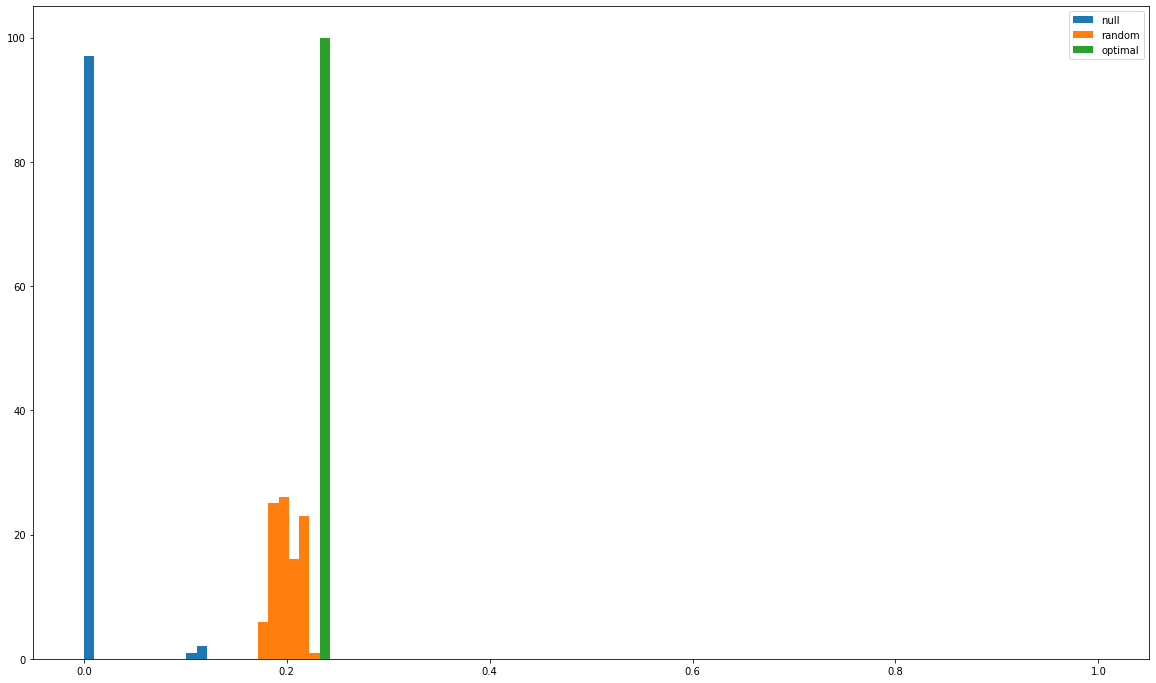

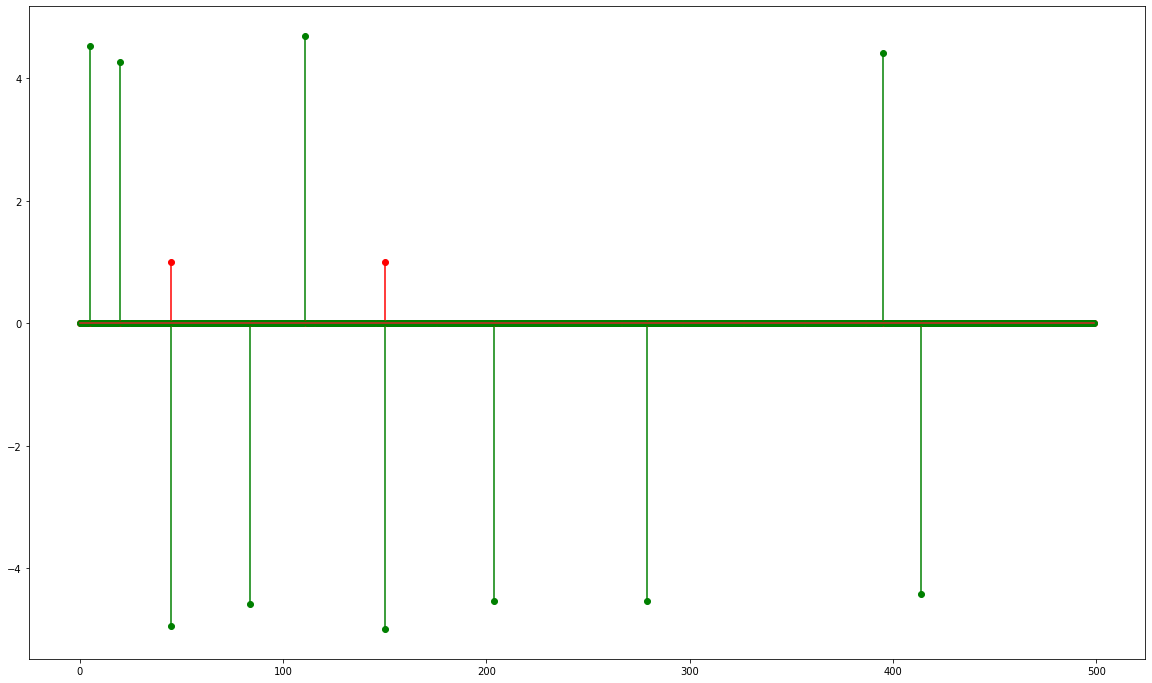

In [3]:
mainro.run_nulls()
mainro.coverage()

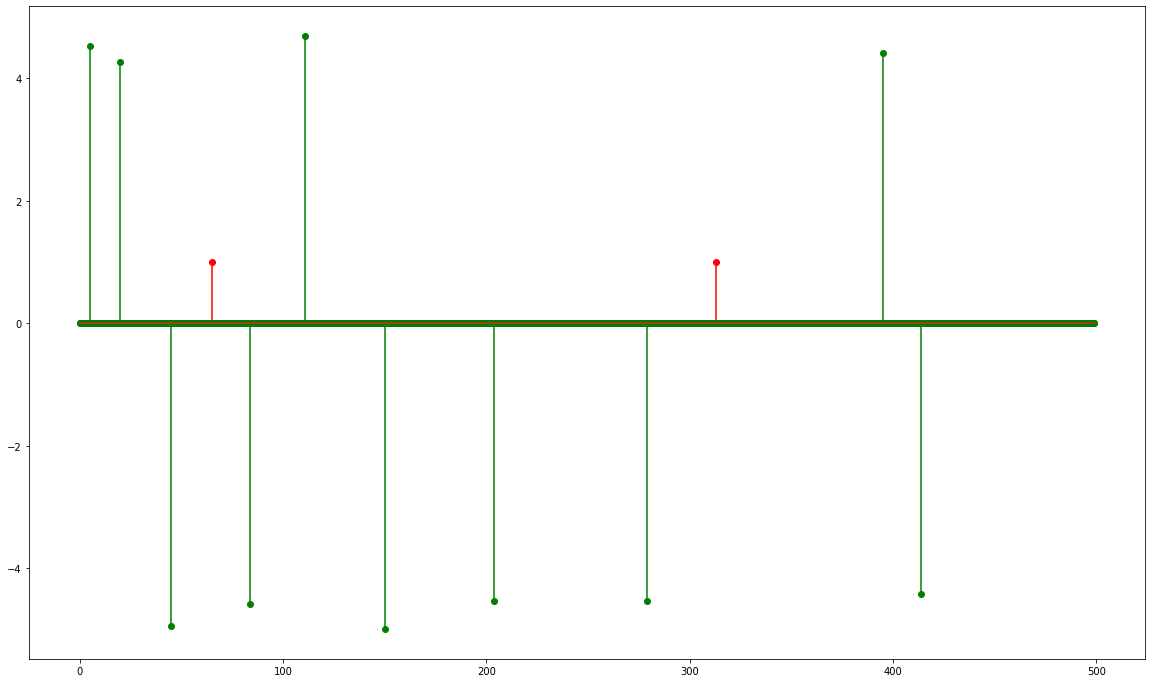

In [4]:
mainro.design_H(family='rand_all')
mainro.coverage()

## Calculating and Assessing a Readout

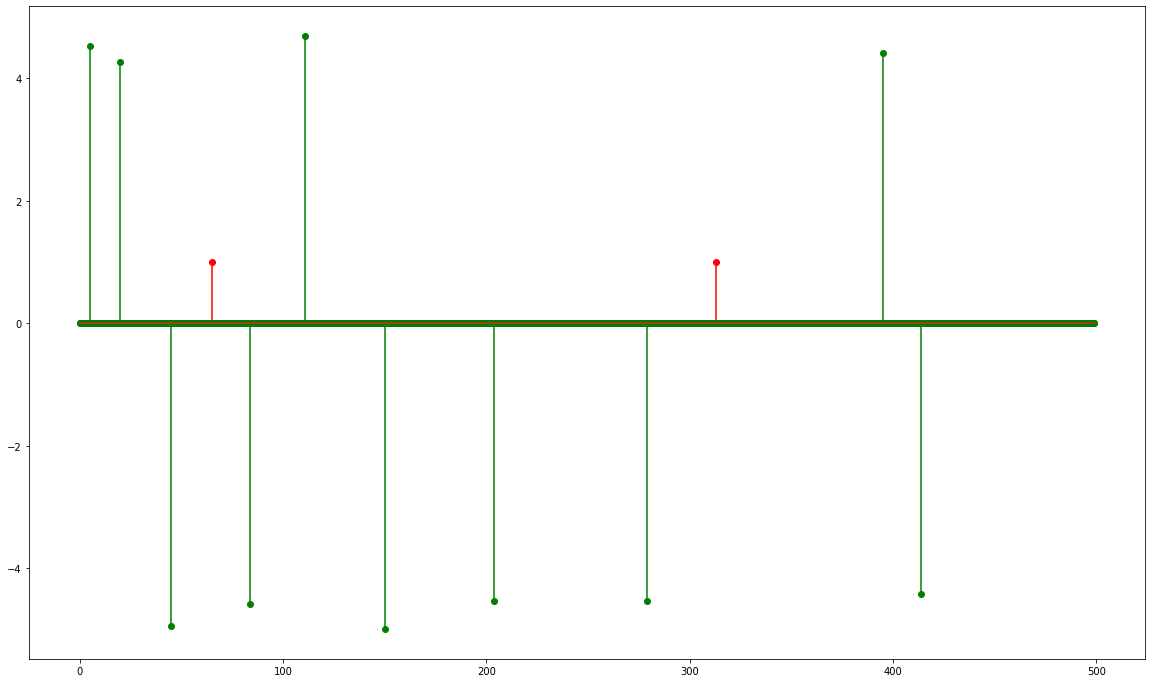

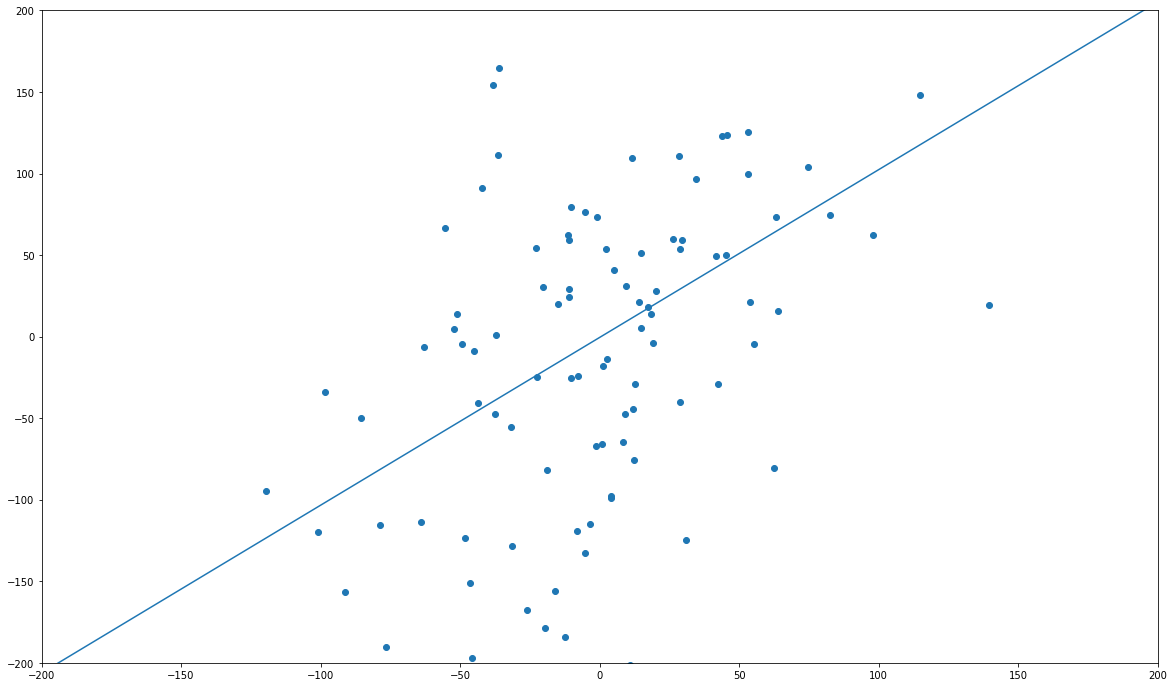

In [5]:
mainro.coverage()
plt.figure()
mainro = readout(M=8)
mainro.find_readout()
mainro.plot_assess(style='evr')